In [5]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
using LinearAlgebra, Plots
import Convex as cvx 
import MeshCat as mc 
using Test
using Random
import Convex as cvx 
import ECOS      
include(joinpath(@__DIR__,"ref_traj.jl"))


  Activating environment at `c:\Users\scott\Documents\OCRL\MPCwZAC\Project.toml`

create_ref_hover (generic function with 1 method)

In [6]:
function quadrotor_dynamics(state, inputs, dt)
    # Unpack the state
    x, y, z, vx, vy, vz, phi, theta, psi, p, q, r = state
    
    # Unpack the inputs
    thrust, tau_phi, tau_theta, tau_psi = inputs
    
    # Constants
    m = 1.0  # Mass of the quadrotor
    g = 9.81  # Gravitational acceleration
    Ix = 0.01  # Moment of inertia around x-axis
    Iy = 0.01  # Moment of inertia around y-axis
    Iz = 0.02  # Moment of inertia around z-axis
    
    # Translational dynamics
    ax = 0
    ay = 0
    az = thrust / m - g
    
    # Rotational dynamics
    p_dot = tau_phi / Ix
    q_dot = tau_theta / Iy
    r_dot = tau_psi / Iz
    
    # Integrate to get the new state
    new_state = [
        x + vx * dt,
        y + vy * dt,
        z + vz * dt,
        vx + ax * dt,
        vy + ay * dt,
        vz + az * dt,
        phi + p * dt,
        theta + q * dt,
        psi + r * dt,
        p + p_dot * dt,
        q + q_dot * dt,
        r + r_dot * dt
    ]
    
    return new_state
end

function linearize(state_eq, input_eq, dt)
    n_states = length(state_eq)
    n_inputs = length(input_eq)
    
    A = zeros(n_states, n_states)
    B = zeros(n_states, n_inputs)
    
    epsilon = 1e-6
    
    for i in 1:n_states
        delta = zeros(n_states)
        delta[i] = epsilon
        state_plus = state_eq + delta
        state_minus = state_eq - delta
        
        f_plus = quadrotor_dynamics(state_plus, input_eq, dt)
        f_minus = quadrotor_dynamics(state_minus, input_eq, dt)
        
        A[:, i] = (f_plus - f_minus) / (2 * epsilon)
    end
    
    for i in 1:n_inputs
        delta = zeros(n_inputs)
        delta[i] = epsilon
        input_plus = input_eq + delta
        input_minus = input_eq - delta
        
        f_plus = quadrotor_dynamics(state_eq, input_plus, dt)
        f_minus = quadrotor_dynamics(state_eq, input_minus, dt)
        
        B[:, i] = (f_plus - f_minus) / (2 * epsilon)
    end
    
    return A, B
end

function kalman_filter(A, B, C, D, Q, R, x_hat, P, u, y, W, w)
    # w is the wind input 
    # W is the system response to wind 
    x_hat_minus = A * x_hat + B * u + W * w
    P_minus = A * P * A' + Q
    
    K = P_minus * C' / (C * P_minus * C' + R)
    x_hat_plus = x_hat_minus + K * (y - C * x_hat_minus - D * u)
    P_plus = (I - K * C) * P_minus
    
    return x_hat_plus, P_plus
end

function update_wind(current_wind, dt, intensity)
    # Random walk update
    d_wind = randn(size(current_wind)) .* sqrt(intensity * dt)
    new_wind = current_wind + d_wind
    return new_wind
end



update_wind (generic function with 1 method)

In [7]:
"""
`u = convex_mpc(A,B,X_ref_window,xic,xg,u_min,u_max,N_mpc)`

setup and solve the above optimization problem, returning the 
first control u_1 from the solution (should be a length nu 
Vector{Float64}).  
"""
function convex_mpc(A::Matrix, # discrete dynamics matrix A
                    B::Matrix, # discrete dynamics matrix B
                    X_ref_window::Vector{Vector{Float64}}, # reference trajectory for this window 
                    xic::Vector, # current state x 
                    u_min::Vector, # lower bound on u 
                    u_max::Vector, # upper bound on u 
                    N_mpc::Int64,  # length of MPC window (horizon)
                    wind_dynamics::Matrix, # discrete dynamics of wind W
                    wind_velocity::Vector # current wind state w
                    )::Vector{Float64} # return the first control command of the solved policy 
    
    # get our sizes for state and control
    nx,nu = size(B)
    
    # check sizes 
    @assert size(A) == (nx, nx)
    @assert length(xic) == nx 
    @assert length(X_ref_window) == N_mpc 
        
    # LQR cost
    Q = diagm(ones(nx))
    R = diagm(ones(nu))

    # variables we are solving for
    X = cvx.Variable(nx,N_mpc)
    U = cvx.Variable(nu,N_mpc-1)

    obj = 0 

    for i = 1:N_mpc-1
        obj += (0.5*cvx.quadform(X[:,i]-X_ref_window[i], Q)+0.5*cvx.quadform(U[:,i], R))
    end
    obj += 0.5*cvx.quadform(X[:,N_mpc]-X_ref_window[N_mpc], Q)

    # create problem with objective
    prob = cvx.minimize(obj)

    prob.constraints += (X[:,1] == xic)
    for i = 1:N_mpc-1
        prob.constraints += (X[:,i+1] == A*X[:,i] + B*U[:,i] + wind_dynamics * wind_velocity)
        prob.constraints += (u_min ≤ U[:,i])
        prob.constraints += (U[:,i] ≤ u_max)
    end
    

    # solve problem 
    cvx.solve!(prob, ECOS.Optimizer; silent_solver = true)

    # get X and U solutions 
    X = X.value
    U = U.value
    
    # return first control U 
    return U[:,1]
end

convex_mpc

In [28]:
# Drone parameters
mass = 1

# Simulation parameters
dt = 0.01
N = 100
time = 1:N
n_states = 12
n_inputs = 4
state_eq = zeros(n_states)
input_eq = [9.81, 0, 0, 0]

# MPC Parameters
Q = I * 0.1
R = I * 0.1
N_mpc = 20
u_min = zeros(n_inputs)
u_max = 10000*ones(n_inputs)

# Initialize wind parameters
wind_dynamics = zeros(n_states, 3)
wind_dynamics[4, 1] = 1  # Wind effect on vx
wind_dynamics[5, 2] = 1  # Wind effect on vy
wind_dynamics[6, 3] = 1  # Wind effect on vz
wind_velocity = [0, 0, 0] # Intensity of the turbulence
wind_intensity = 0.5

# initialize sim variables
x_hat = zeros(n_states)
u_mpc = zeros(n_inputs)
P = I(n_states)
true_state = zeros(n_states)
measurements = true_state


# Generate hover trajectory for hexrotor
X_ref, Uref = create_ref_hover(N+N_mpc, dt, n_inputs, mass)

# check dimensions
@assert length(X_ref[1]) == n_states
@assert length(Uref[1]) == n_inputs

true_states = []
estimated_states = []

# Update simulation loop to include wind update
for i in time
    # Update wind with turbulence model
    #wind_velocity = update_wind(wind_velocity, dt, wind_intensity)

    # Linearize system and run KF
    A, B = linearize(x_hat, u_mpc, dt)
    C = I(n_states)
    D = zeros(n_states, n_inputs)

    x_hat, P = kalman_filter(A, B, C, D, Q, R, x_hat, P, u_mpc, measurements, wind_dynamics, wind_velocity)
    
    push!(estimated_states, x_hat)

    # TODO: given a window of N_mpc timesteps, get current reference trajectory
    X_ref_tilde = X_ref[i:i+N_mpc-1]
    
    # TODO: call convex mpc controller with state estimate 
    u_mpc = convex_mpc(A, B, X_ref_tilde, x_hat, u_min, u_max, N_mpc, wind_dynamics, wind_velocity)


    true_state = quadrotor_dynamics(x_hat, u_mpc, dt)
    push!(true_states, true_state)

    measurements = true_state + randn(n_states) * 0.1

end



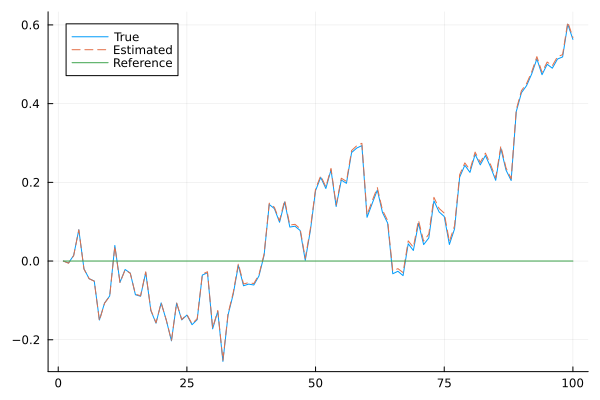

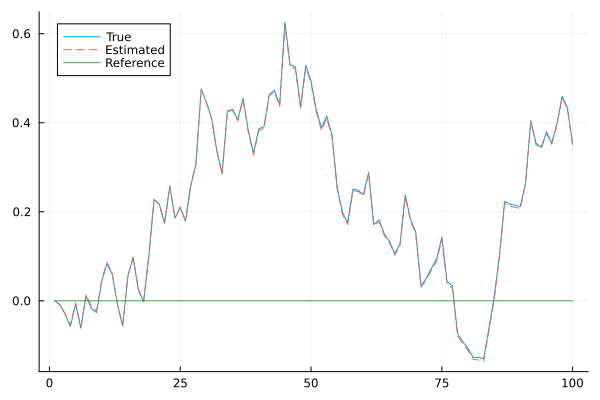

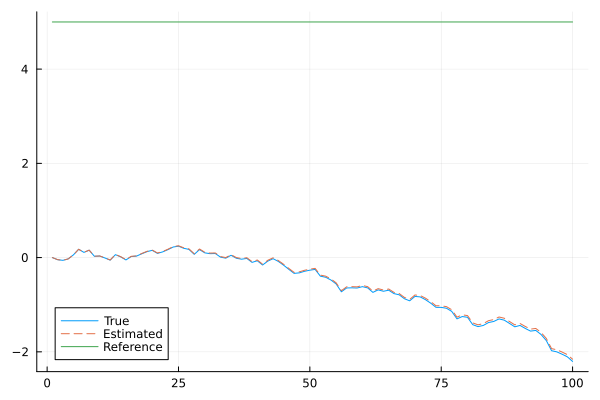

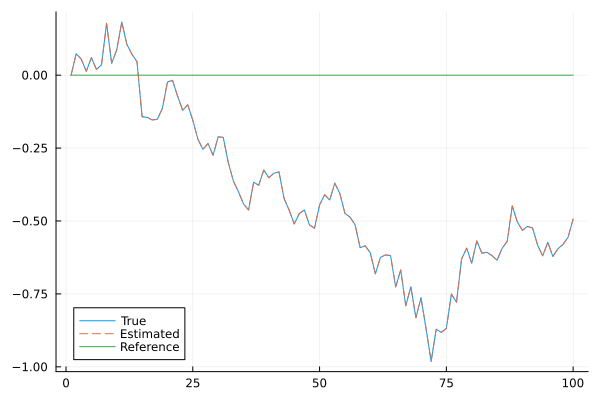

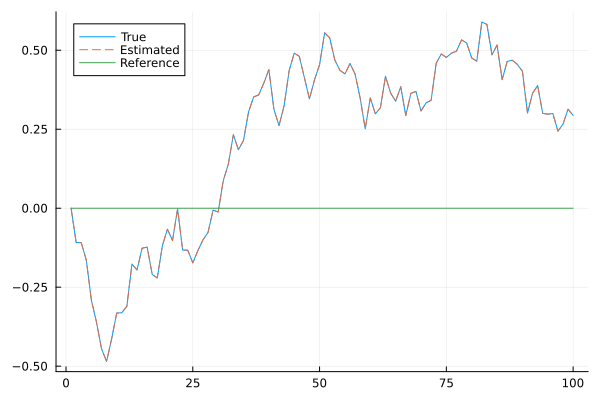

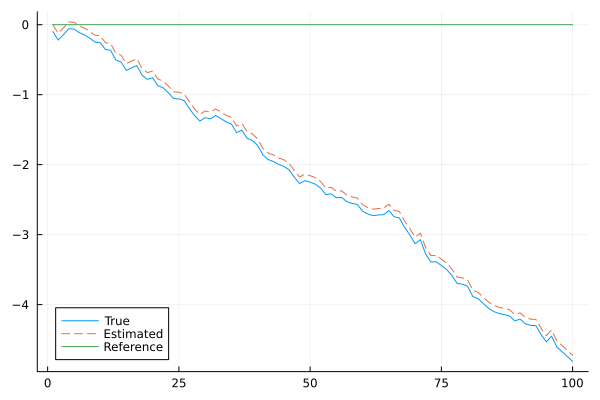

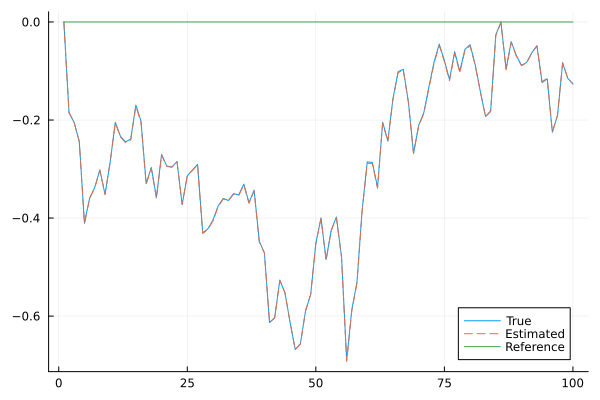

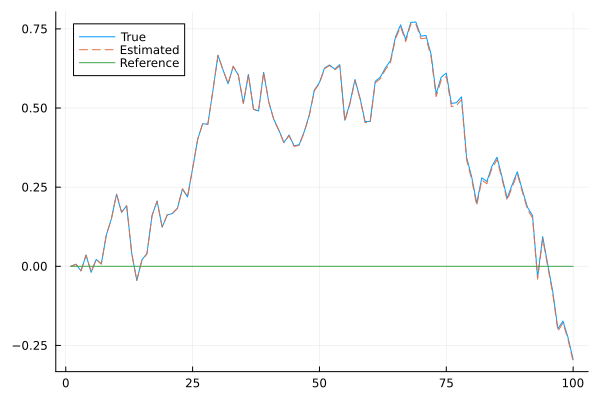

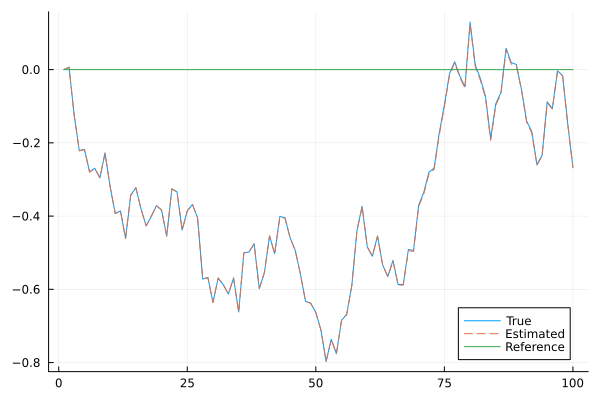

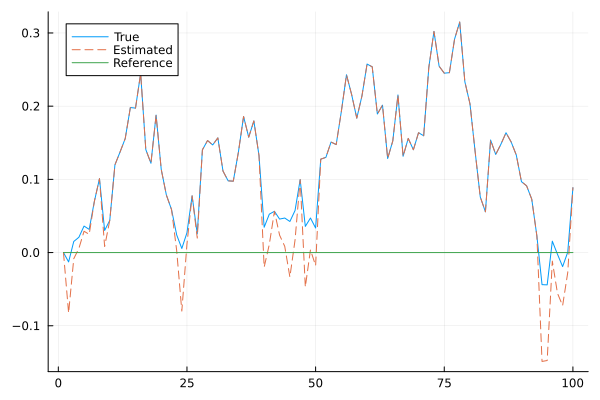

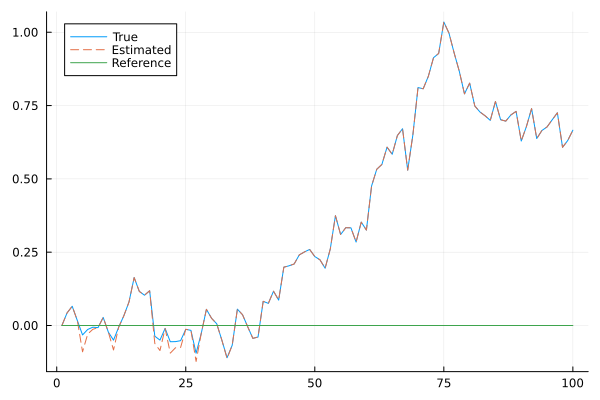

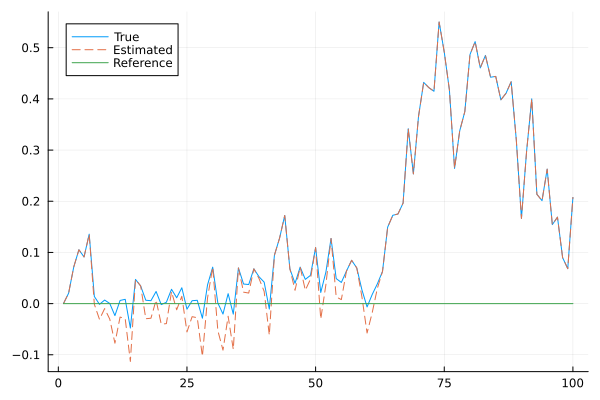

In [29]:

# Convert results to arrays for plotting
true_states_plot = hcat(true_states...)
estimated_states_plot = hcat(estimated_states...)
U_ref_plot = hcat(Uref...)
X_ref_plot = hcat(X_ref...)


# Plotting
for i in 1:n_states
    p = plot(time, true_states_plot[i, :], label="True")
    plot!(time, estimated_states_plot[i, :], label="Estimated", linestyle=:dash)
    plot!(time, X_ref_plot[i, 1:N], label = "Reference")
    display(p)
end